In [1]:
%matplotlib inline

from collections import namedtuple
from typing import Union

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

import sys
sys.path.insert(0, "../")
from weavingspace import Symmetries
from weavingspace import Shape_Matcher
from weavingspace import tiling_utils

### A test polygon

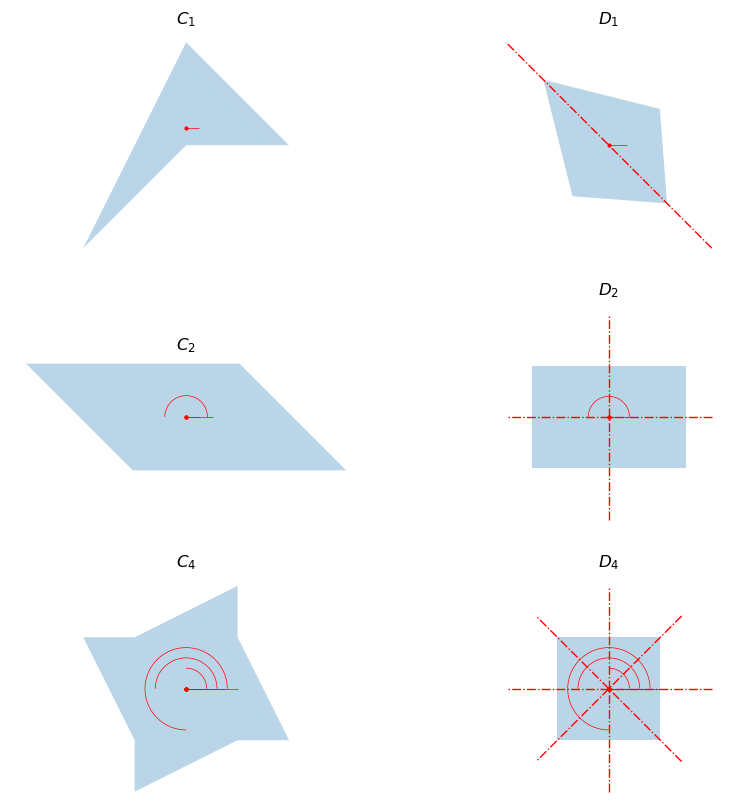

In [2]:
pt_sets = [
  [(50, 50), (150, -50), (50, -50), (-50, -150)], # irregular     C1
  [(30, 30), (35, -35), (-30, -30), (-50, 50)],   # kite          D1
  [(50, 50), (150, -50), (-50, -50), (-150, 50)], # parallelogram C2
  [(75, 50), (75, -50), (-75, -50), (-75, 50)],   # rectangle     D2
  [(50, 50), (100, -50), (50, -50), (-50, -100),  # star thing    C4
   (-50, -50), (-100, 50), (-50, 50), (50, 100)],
  [(50, 50), (50, -50), (-50, -50), (-50, 50)],   # square        D4
]

polys = [geom.Polygon(pts) for pts in pt_sets]
n = len(polys)
nr = int(np.ceil(np.sqrt(n)))
nc = int(np.ceil(n / nr))

fig = pyplot.figure(figsize = (10, 10))
for i, p in enumerate(polys):
  ax = fig.add_subplot(nr, nc, i + 1)
  gpd.GeoSeries([p]).plot(ax = ax, alpha = 0.3)
  s = Symmetries(p)
  g = s.symmetry_group
  ax.set_title(f"${g[0]}_{g[1]}$")
  for i, s in enumerate(s.symmetries):
    s.draw(ax, 
           radius = 10 * (i + 1), 
           mirror_length = 200, w = 5, 
           add_title = False)
  pyplot.axis("off")

So... cyclic symmetries $C_n$ may exist independent of reflection symmetries. But reflection symmetries only exist in pairs with corresponding number of rotational symmetries. This means that there should be a logic in the symmetry detection code like

However... if the question is one of matching a polygon to some other polygon (not finding the 'internal' symmetries of a polygon), then it is possible for the matching transform to be a reflection; it could also be a rotation at the same time, but a standalone reflection becomes a possibility for a shape with $C_1$ as its symmetry group.

In [3]:
poly1 = affine.scale(tiling_utils.get_regular_polygon(500, 6), 1, 1)
p0 = tiling_utils.get_corners(poly1)[0]
poly2 = affine.translate(affine.rotate(poly1, 100, p0), -250, 0)

In [4]:
matcher = Shape_Matcher(poly1)
trs = matcher.get_polygon_matches(poly2)
trs

[rotation   -100.0° POINT (-269.3 -354.9) (-0.174, 0.985, -0.985, -0.174, 33.388, -681.759),
 rotation    -40.0° POINT (-125.0 -990.0) (0.766, 0.643, -0.643, 0.766, 607.115, -311.964),
 rotation     20.0° POINT (-761.7 1811.8) (0.94, -0.342, 0.342, 0.94, 573.726, 369.795),
 rotation     80.0° POINT (-422.9  321.0) (0.174, -0.985, 0.985, 0.174, -33.388, 681.759),
 rotation    140.0° POINT (-360.3   45.5) (-0.766, -0.643, 0.643, -0.766, -607.115, 311.964),
 rotation   -160.0° POINT (-319.5 -134.3) (-0.94, 0.342, -0.342, -0.94, -573.726, -369.795),
 reflection  -70.0° POINT (-332.8  -75.6) (-0.766, -0.643, -0.643, 0.766, -607.115, -311.964),
 reflection -100.0° POINT (-332.8  -75.6) (-0.94, 0.342, 0.342, 0.94, -573.726, 369.795),
 reflection   50.0° POINT (-332.8  -75.6) (-0.174, 0.985, 0.985, 0.174, 33.388, 681.759),
 reflection   20.0° POINT (-332.8  -75.6) (0.766, 0.643, 0.643, -0.766, 607.115, 311.964),
 reflection  -10.0° POINT (-332.8  -75.6) (0.94, -0.342, -0.342, -0.94, 573.726, -

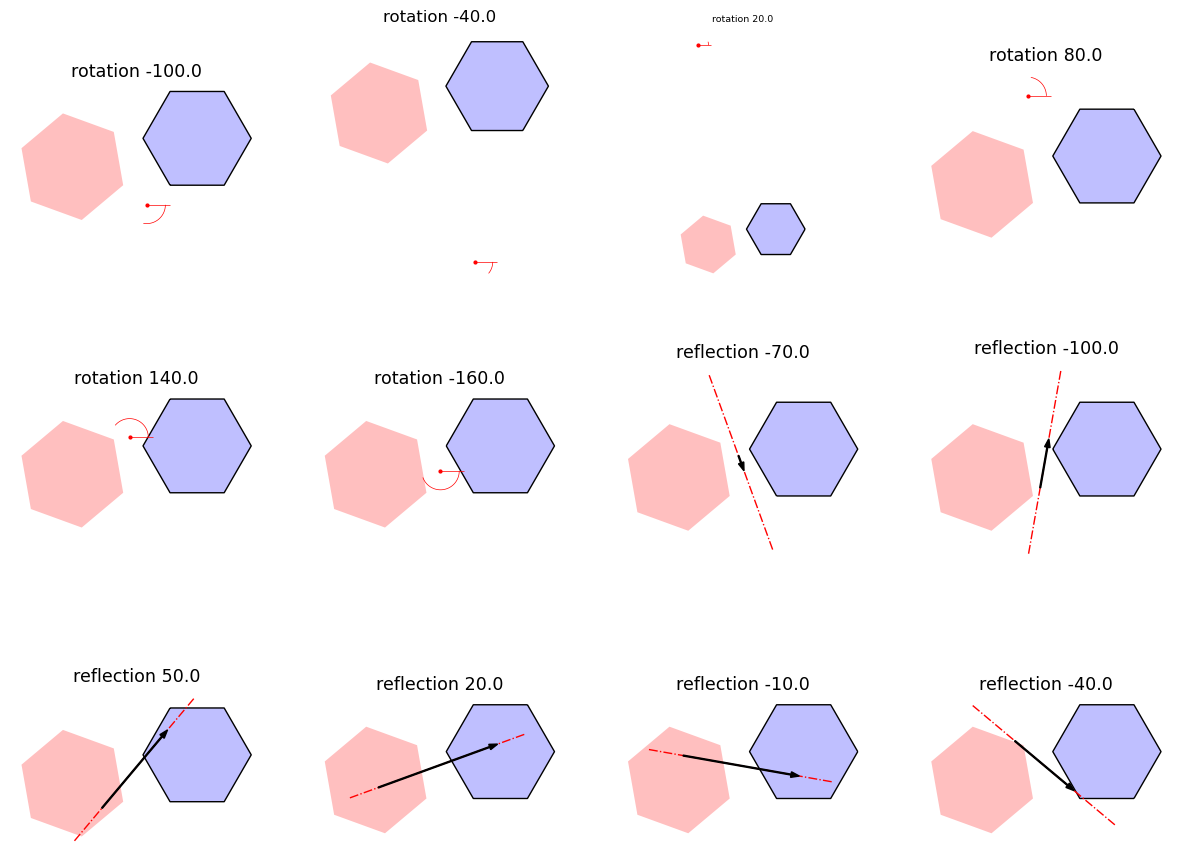

In [5]:
n = len(trs)
nc = int(np.ceil(np.sqrt(n)))
nr = int(np.ceil(n / nc))

fig = pyplot.figure(figsize = (15, 15 * nr/nc))

for i, tr in enumerate(trs):
  ax = fig.add_subplot(nr, nc, i + 1)
  gpd.GeoSeries(
  [poly1, poly2, affine.affine_transform(poly2, tr.transform)]).plot(
    ax = ax, fc = ["#0000ff40", "#ff000040", "#00000000"], lw = [0, 0, 1], 
    ec = "k")
  tr.draw(ax, radius = 100, w = 5, mirror_length = 1000, c = poly2.centroid)
  pyplot.axis("off")
